## GB_FX Price only Monthly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<400
  2000-03: hist<400
  2000-04: hist<400
  2000-05: hist<400
  2000-06: hist<400
  2000-07: hist<400
  2000-08: hist<400
  2000-09: hist<400
  2000-10: hist<400
  2000-11: hist<400
  2000-12: hist<400
  2001-01: hist<400
  2001-02: hist<400
  2001-03: hist<400

=== Model performance (monthly mean, EUR/NOK) ===
Observations: 296
RMSE (level): 0.170724
MAE  (level): 0.112351
Directional accuracy: 195/295 (66.1%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: 0.4539
p-value     : 0.6499


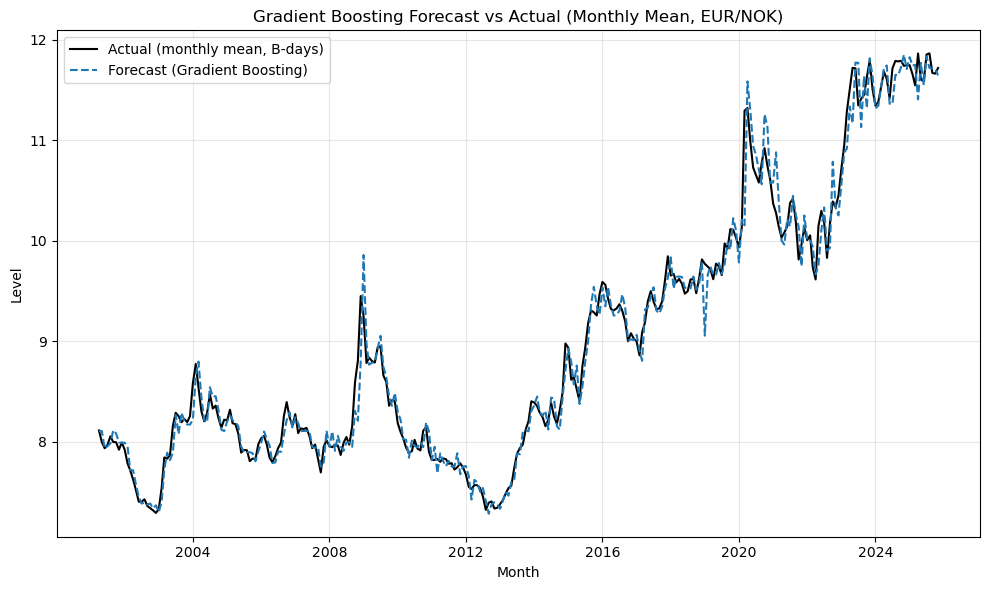

Saved: GB_Monthly.png
Saved: GB_Monthly.pdf


In [2]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (monthly, levels), point forecast only
# PARALLEL OUTER LOOP
# - Data: variables_daily.csv (daily wide), but ONLY EUR_NOK column used
# - Forward-filled to daily calendar + business-day truth
# - Cut: last business day of previous month
# - Model: GradientBoostingRegressor on EUR_NOK daily lag features
# - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
# - Guard: max_horizon (drop months with H > max_horizon)
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    # Same link as panel-script
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    min_hist_days: int = 400
    max_lags: int = 20
    max_horizon: int = 64  # Must exceed longest month (~31 days)

    # GB hyperparameters
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Monthly.png"
    fig_pdf: str = "GB_Monthly.pdf"

CFG = Config()
TARGET_SERIES = "EUR_NOK"


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (ONLY EUR_NOK)
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load variables_daily.csv, but only Date + EUR_NOK are used.

    Returns:
      S_b: EUR_NOK on business days (B), ffilled (truth/aggregation base)
      S_d: EUR_NOK on calendar days (D), ffilled (model inputs/recursion)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", TARGET_SERIES}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    df[TARGET_SERIES] = pd.to_numeric(df[TARGET_SERIES], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day series (truth/aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily calendar series (inputs/recursion)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    S_d = df[TARGET_SERIES].reindex(full_idx).ffill().astype(float)
    S_d.index.name = "DATE"
    S_d.name = TARGET_SERIES

    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering (lags)
# -----------------------------
def make_lag_matrix(y: pd.Series, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """One-step daily lag matrix for EUR_NOK."""
    df = pd.DataFrame({'y': y})
    for k in range(1, max_lags + 1):
        df[f'lag{k}'] = df['y'].shift(k)
    df = df.dropna()
    X = df[[f'lag{k}' for k in range(1, max_lags + 1)]].values
    y_target = df['y'].values
    return X, y_target


# -----------------------------
# Gradient Boosting one-step
# -----------------------------
def fit_gb_one_step(y_hist_daily: pd.Series) -> GradientBoostingRegressor:
    """Fit GB for one-step ahead daily prediction."""
    X, y_target = make_lag_matrix(y_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model


def recursive_daily_forecast(model: GradientBoostingRegressor, y_hist_daily: pd.Series, H: int) -> pd.Series:
    """Recursive EUR_NOK daily forecasts for H days."""
    hist = y_hist_daily.values.tolist()
    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")
        x = np.array(hist[-CFG.max_lags:][::-1], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist.append(yhat)
    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward (parallel)
# -----------------------------
def walk_forward_gb_monthly_parallel(S_b: pd.Series, S_d: pd.Series, n_jobs_outer: int = -1) -> pd.DataFrame:
    """Monthly walk-forward with GB on EUR_NOK only, with max_horizon guard."""
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model = fit_gb_one_step(hist_d)
        pf = recursive_daily_forecast(model, hist_d, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend="loky")(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs RW)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse"):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Gradient Boosting)")

    plt.title("Gradient Boosting Forecast vs Actual (Monthly Mean, EUR/NOK)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    df_eval = walk_forward_gb_monthly_parallel(S_b, S_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
